In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v3 import Autoencoder
from tools.GRU_AR_v2 import AR_RNN_GRU as RNN_GRU

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpoin?tAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2022-11-11 23:23:29.339163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 23:23:29.339657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 23:23:29.402073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 23:23:29.402335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 23:23:29.402640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 23:23:29.404661: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-11 23:23:29.405189: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 23:23:29.405553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 23:23:29.405868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful N

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_020'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_rnn/AR_rnn_000'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_rnn_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in AR_rnn_specific_data, set to 1.")
        skip_intermediate = 1

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    
# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    fl = np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True)
    normalization_arr = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']

print('dir_name_ARrnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)
all_data = fl['all_data']
boundary_idx_arr = fl['boundary_idx_arr']
normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
initial_t0 = fl['initial_t0']
init_state_mat = fl['init_state_mat']
lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_ARrnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_020
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_020
data_dir_idx: 004
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

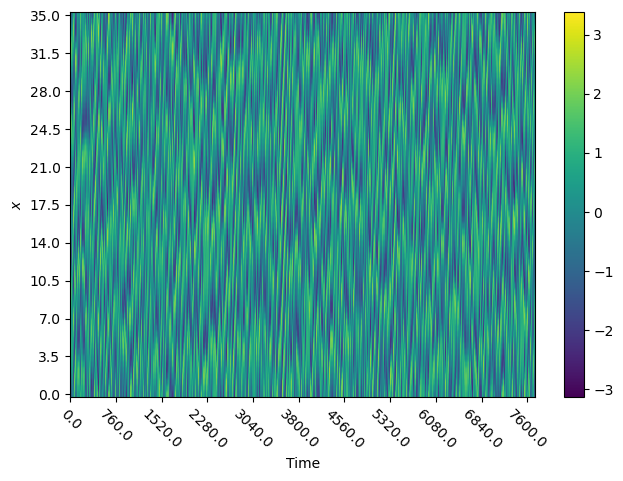

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# delaing with normalizing the data before feeding into autoencoder
if normalizeforae_flag == True:
    for i in range(numpoints_xgrid):
        all_data[:, i] -= normalization_constant_arr_aedata[0, i]
        all_data[:, i] /= normalization_constant_arr_aedata[1, i]

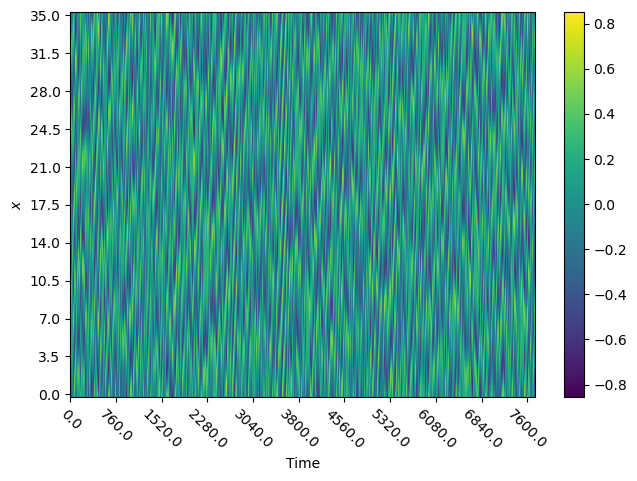

In [16]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [17]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae_og = dir_name_ae
#     dir_name_ae_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_'+ae_idx
#     dir_name_ae = dir_name_ae_temp

load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae = dir_name_ae_og

In [18]:
ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [19]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)
num_latent_states = latent_states_all.shape[1]

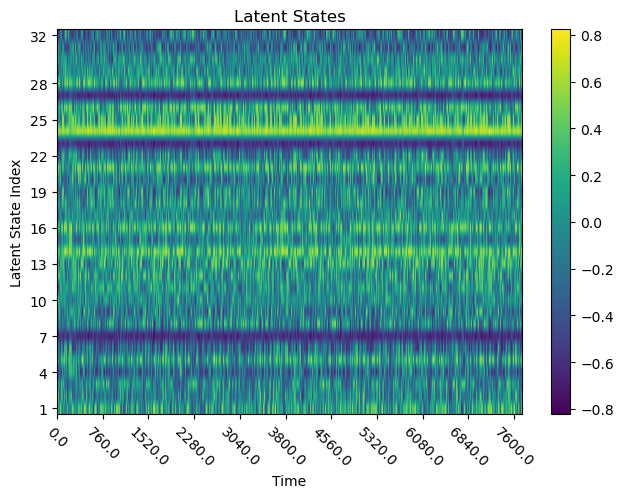

In [20]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [21]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [22]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 2
    num_timesteps_warmup = 50
    T_sample_input = (num_timesteps_warmup+0.1)*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 1/4
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'skip_intermediate':skip_intermediate,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [23]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    normalization_arr_external=normalization_arr_rnn,
    return_OrgDataIdxArr=False,
    skip_intermediate=skip_intermediate,
)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [24]:
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)

In [25]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-4, 1e-5]
    epochs = 2000
    patience = 25  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-4  # weight for regularizer

    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )

In [26]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [27]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [num_train]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [num_train]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [num_val]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [num_train]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [cum_samples-num_train-num_val]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [cum_samples-num_train-num_val]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# further shuffling
idx = np.arange(0, training_data_rnn_input.shape[0])
np.random.shuffle(idx)
training_data_rnn_input = training_data_rnn_input[idx]
training_data_rnn_output = training_data_rnn_output[idx]

idx = np.arange(0, val_data_rnn_input.shape[0])
np.random.shuffle(idx)
val_data_rnn_input = val_data_rnn_input[idx]
val_data_rnn_output = val_data_rnn_output[idx]

idx = np.arange(0, testing_data_rnn_input.shape[0])
np.random.shuffle(idx)
testing_data_rnn_input = testing_data_rnn_input[idx]
testing_data_rnn_output = testing_data_rnn_output[idx]

In [28]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'

    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                T_input=T_sample_input,
                T_output=T_sample_output,
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            T_input=T_sample_input,
            T_output=T_sample_output,
        )
    save_path = dir_name_ARrnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_ARrnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file
        )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_ARrnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_ARrnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
        # wt_file = dir_name_ARrnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)

In [29]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_ARrnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_ARrnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [30]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_ARrnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/2000
10/10 [==============================] - ETA: 0s - loss: 0.1741 - tot_time: 0h 0m 30.3s

Epoch 1: val_loss improved from inf to 0.17592, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 30s 491ms/step - loss: 0.1741 - val_loss: 0.1759
Epoch 2/2000
10/10 [==============================] - ETA: 0s - loss: 0.1731 - tot_time: 0h 0m 32.5s

Epoch 2: val_loss improved from 0.17592 to 0.17482, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/checkpoint
 - saving loss histo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 220ms/step - loss: 0.1579 - val_loss: 0.1615
Epoch 19/2000
10/10 [==============================] - ETA: 0s - loss: 0.1580 - tot_time: 0h 1m 9.5s

Epoch 19: val_loss did not improve from 0.16147
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 209ms/step - loss: 0.1580 - val_loss: 0.1620
Epoch 20/2000
10/10 [==============================] - ETA: 0s - loss: 0.1573 - tot_time: 0h 1m 11.6s

Epoch 20: val_loss improved from 0.16147 to 0.16115, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==================

Epoch 38/2000
10/10 [==============================] - ETA: 0s - loss: 0.1531 - tot_time: 0h 1m 50.4s

Epoch 38: val_loss did not improve from 0.15785
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 212ms/step - loss: 0.1531 - val_loss: 0.1581
Epoch 39/2000
10/10 [==============================] - ETA: 0s - loss: 0.1526 - tot_time: 0h 1m 52.5s

Epoch 39: val_loss improved from 0.15785 to 0.15724, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 221ms/step - loss: 0.1526 - val_loss: 0.1572
Epoch 40/2000
10/10 [==============================] - ETA: 0s - loss: 0.1527 - tot_time: 0h 1m 54.7s

Epoch 40: val_loss did not improve from 0.15724
 -

Epoch 59/2000
10/10 [==============================] - ETA: 0s - loss: 0.1498 - tot_time: 0h 2m 35.4s

Epoch 59: val_loss improved from 0.15491 to 0.15454, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 222ms/step - loss: 0.1498 - val_loss: 0.1545
Epoch 60/2000
10/10 [==============================] - ETA: 0s - loss: 0.1497 - tot_time: 0h 2m 37.6s

Epoch 60: val_loss did not improve from 0.15454
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 214ms/step - loss: 0.1497 - val_loss: 0.1546
Epoch 61/2000
10/10 [==============================] - ETA: 0s - loss: 0.1496 - tot_time: 0h 2m 39.8s

Epoch 61: val_loss did not improve from 0.15454
 -

Epoch 80/2000
10/10 [==============================] - ETA: 0s - loss: 0.1463 - tot_time: 0h 3m 20.6s

Epoch 80: val_loss improved from 0.15227 to 0.15178, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 221ms/step - loss: 0.1463 - val_loss: 0.1518
Epoch 81/2000
10/10 [==============================] - ETA: 0s - loss: 0.1461 - tot_time: 0h 3m 22.8s

Epoch 81: val_loss did not improve from 0.15178
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 215ms/step - loss: 0.1461 - val_loss: 0.1539
Epoch 82/2000
10/10 [==============================] - ETA: 0s - loss: 0.1467 - tot_time: 0h 3m 24.9s

Epoch 82: val_loss did not improve from 0.15178
 -

Epoch 101/2000
10/10 [==============================] - ETA: 0s - loss: 0.1438 - tot_time: 0h 4m 5.6s

Epoch 101: val_loss improved from 0.14967 to 0.14964, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 224ms/step - loss: 0.1438 - val_loss: 0.1496
Epoch 102/2000
10/10 [==============================] - ETA: 0s - loss: 0.1434 - tot_time: 0h 4m 7.8s

Epoch 102: val_loss improved from 0.14964 to 0.14950, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 225ms/step - loss: 0.1434 - val_loss: 0.1495
Epoch 103/2000
10/10 [====================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 226ms/step - loss: 0.1398 - val_loss: 0.1455
Epoch 122/2000
10/10 [==============================] - ETA: 0s - loss: 0.1399 - tot_time: 0h 4m 50.9s

Epoch 122: val_loss did not improve from 0.14554
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 213ms/step - loss: 0.1399 - val_loss: 0.1462
Epoch 123/2000
10/10 [==============================] - ETA: 0s - loss: 0.1404 - tot_time: 0h 4m 53.0s

Epoch 123: val_loss improved from 0.14554 to 0.14526, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [=============

10/10 [==============================] - ETA: 0s - loss: 0.1363 - tot_time: 0h 5m 33.8s

Epoch 142: val_loss did not improve from 0.14282
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 211ms/step - loss: 0.1363 - val_loss: 0.1431
Epoch 143/2000
10/10 [==============================] - ETA: 0s - loss: 0.1360 - tot_time: 0h 5m 35.9s

Epoch 143: val_loss improved from 0.14282 to 0.14239, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 222ms/step - loss: 0.1360 - val_loss: 0.1424
Epoch 144/2000
10/10 [==============================] - ETA: 0s - loss: 0.1357 - tot_time: 0h 5m 38.1s

Epoch 144: val_loss did not improve from 0.14239
 - saving l

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 212ms/step - loss: 0.1329 - val_loss: 0.1401
Epoch 163/2000
10/10 [==============================] - ETA: 0s - loss: 0.1338 - tot_time: 0h 6m 18.8s

Epoch 163: val_loss did not improve from 0.13983
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 213ms/step - loss: 0.1338 - val_loss: 0.1421
Epoch 164/2000
10/10 [==============================] - ETA: 0s - loss: 0.1338 - tot_time: 0h 6m 21.0s

Epoch 164: val_loss improved from 0.13983 to 0.13953, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [=============

Epoch 183/2000
10/10 [==============================] - ETA: 0s - loss: 0.1299 - tot_time: 0h 7m 1.8s

Epoch 183: val_loss improved from 0.13781 to 0.13706, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 219ms/step - loss: 0.1299 - val_loss: 0.1371
Epoch 184/2000
10/10 [==============================] - ETA: 0s - loss: 0.1292 - tot_time: 0h 7m 4.0s

Epoch 184: val_loss improved from 0.13706 to 0.13667, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 230ms/step - loss: 0.1292 - val_loss: 0.1367
Epoch 185/2000
10/10 [====================

Epoch 204/2000
10/10 [==============================] - ETA: 0s - loss: 0.1265 - tot_time: 0h 7m 46.8s

Epoch 204: val_loss did not improve from 0.13566
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 211ms/step - loss: 0.1265 - val_loss: 0.1377
Epoch 205/2000
10/10 [==============================] - ETA: 0s - loss: 0.1258 - tot_time: 0h 7m 49.0s

Epoch 205: val_loss improved from 0.13566 to 0.13551, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 225ms/step - loss: 0.1258 - val_loss: 0.1355
Epoch 206/2000
10/10 [==============================] - ETA: 0s - loss: 0.1259 - tot_time: 0h 7m 51.2s

Epoch 206: val_loss did not improve from 0.13

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 214ms/step - loss: 0.1232 - val_loss: 0.1353
Epoch 226/2000
10/10 [==============================] - ETA: 0s - loss: 0.1232 - tot_time: 0h 8m 33.9s

Epoch 226: val_loss did not improve from 0.13386
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 213ms/step - loss: 0.1232 - val_loss: 0.1353
Epoch 227/2000
10/10 [==============================] - ETA: 0s - loss: 0.1245 - tot_time: 0h 8m 36.0s

Epoch 227: val_loss did not improve from 0.13386
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 213ms/step - loss: 0.1245 - val_loss: 0.1356
Epoch 228/2000
10/10 [==================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 212ms/step - loss: 0.1214 - val_loss: 0.1335
Epoch 248/2000
10/10 [==============================] - ETA: 0s - loss: 0.1199 - tot_time: 0h 9m 20.7s

Epoch 248: val_loss did not improve from 0.13277
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 213ms/step - loss: 0.1199 - val_loss: 0.1329
Epoch 249/2000
10/10 [==============================] - ETA: 0s - loss: 0.1201 - tot_time: 0h 9m 22.8s

Epoch 249: val_loss improved from 0.13277 to 0.13233, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [=============

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 213ms/step - loss: 0.1183 - val_loss: 0.1316
Epoch 269/2000
10/10 [==============================] - ETA: 0s - loss: 0.1177 - tot_time: 0h 10m 5.7s

Epoch 269: val_loss did not improve from 0.13078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 212ms/step - loss: 0.1177 - val_loss: 0.1343
Epoch 270/2000
10/10 [==============================] - ETA: 0s - loss: 0.1163 - tot_time: 0h 10m 7.8s

Epoch 270: val_loss improved from 0.13078 to 0.13047, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [=============

Epoch 290/2000
10/10 [==============================] - ETA: 0s - loss: 0.1150 - tot_time: 0h 10m 50.6s

Epoch 290: val_loss did not improve from 0.13039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 212ms/step - loss: 0.1150 - val_loss: 0.1320
Epoch 291/2000
10/10 [==============================] - ETA: 0s - loss: 0.1141 - tot_time: 0h 10m 52.7s

Epoch 291: val_loss did not improve from 0.13039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 211ms/step - loss: 0.1141 - val_loss: 0.1306
Epoch 292/2000
10/10 [==============================] - ETA: 0s - loss: 0.1138 - tot_time: 0h 10m 54.8s

Epoch 292: val_loss did not improve from 0.13039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoin

Epoch 311/2000
10/10 [==============================] - ETA: 0s - loss: 0.1133 - tot_time: 0h 11m 35.6s

Epoch 311: val_loss did not improve from 0.12855
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 215ms/step - loss: 0.1133 - val_loss: 0.1313
Epoch 312/2000
10/10 [==============================] - ETA: 0s - loss: 0.1122 - tot_time: 0h 11m 37.7s

Epoch 312: val_loss did not improve from 0.12855
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 214ms/step - loss: 0.1122 - val_loss: 0.1288
Epoch 313/2000
10/10 [==============================] - ETA: 0s - loss: 0.1101 - tot_time: 0h 11m 39.8s

Epoch 313: val_loss did not improve from 0.12855
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoin

Epoch 333/2000
10/10 [==============================] - ETA: 0s - loss: 0.1080 - tot_time: 0h 12m 22.6s

Epoch 333: val_loss did not improve from 0.12786
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 216ms/step - loss: 0.1080 - val_loss: 0.1325
Epoch 334/2000
10/10 [==============================] - ETA: 0s - loss: 0.1091 - tot_time: 0h 12m 24.7s

Epoch 334: val_loss improved from 0.12786 to 0.12710, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 219ms/step - loss: 0.1091 - val_loss: 0.1271
Epoch 335/2000
10/10 [==============================] - ETA: 0s - loss: 0.1082 - tot_time: 0h 12m 26.9s

Epoch 335: val_loss did not improve from 0

Epoch 355/2000
10/10 [==============================] - ETA: 0s - loss: 0.1055 - tot_time: 0h 13m 9.6s

Epoch 355: val_loss did not improve from 0.12710
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 215ms/step - loss: 0.1055 - val_loss: 0.1308
Epoch 356/2000
10/10 [==============================] - ETA: 0s - loss: 0.1051 - tot_time: 0h 13m 11.7s

Epoch 356: val_loss did not improve from 0.12710
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 216ms/step - loss: 0.1051 - val_loss: 0.1290
Epoch 357/2000
10/10 [==============================] - ETA: 0s - loss: 0.1050 - tot_time: 0h 13m 13.8s

Epoch 357: val_loss did not improve from 0.12710
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoint

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 211ms/step - loss: 0.1029 - val_loss: 0.1317
Epoch 18/2000
10/10 [==============================] - ETA: 0s - loss: 0.1029 - tot_time: 0h 13m 56.6s

Epoch 18: val_loss did not improve from 0.12710
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 213ms/step - loss: 0.1029 - val_loss: 0.1310
Epoch 19/2000
10/10 [==============================] - ETA: 0s - loss: 0.1028 - tot_time: 0h 13m 58.7s

Epoch 19: val_loss did not improve from 0.12710
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint
10/10 [==============================] - 2s 212ms/step - loss: 0.1028 - val_loss: 0.1314
Epoch 20/2000
10/10 [=====================

In [31]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = rnn_net.evaluate(
        testing_data_rnn_input, testing_data_rnn_output,
    )

    save_path = dir_name_ARrnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

3/3 [==============================] - 0s 54ms/step - loss: 0.1297


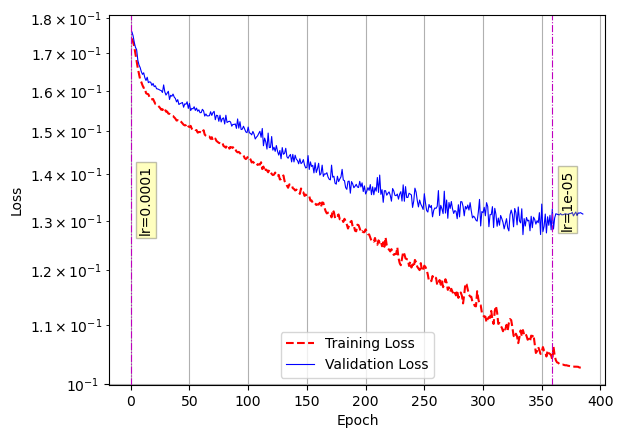

In [32]:
# plotting losses
dir_name_plot = dir_name_ARrnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_plot+'{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


data_idx : 54


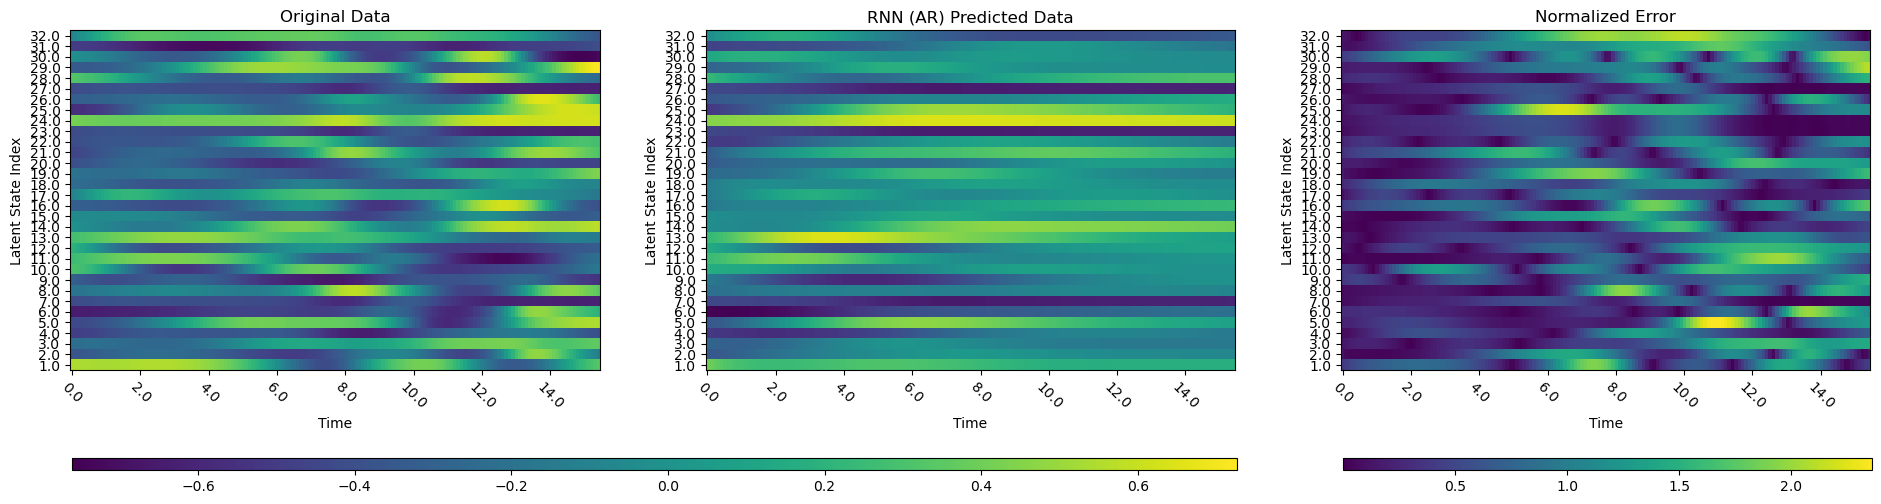

In [33]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ARrnn,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (AR) Predicted Data')

In [34]:
prediction.shape, data_out.shape

((1, 155, 32), (155, 32))

In [35]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = data.copy()
    shape = new_data.shape
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

case 1, data_idx : 44


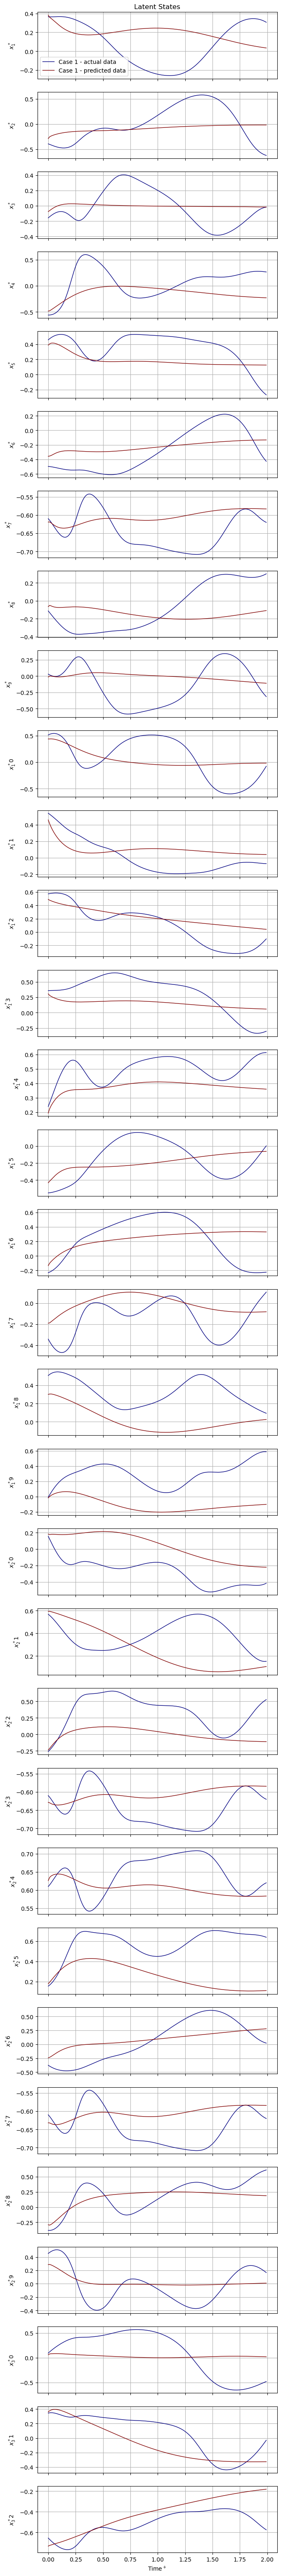


0.09051938166899254


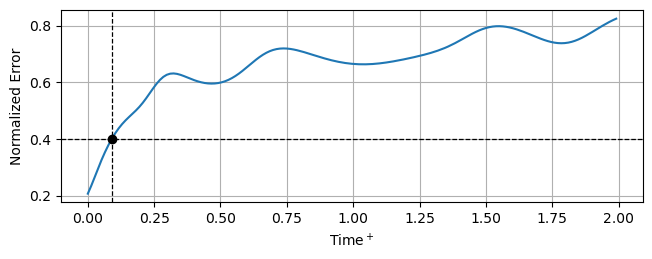

In [36]:
data_in = testing_data_rnn_input
data_out = testing_data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
# for i in range(len(rnn_data_boundary_idx_arr)):
#     if data_idx < rnn_data_boundary_idx_arr[i]:
#         case_idx = i
#         break
case_idx = 0
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]
# data_out = rescale_data(data_out, normalization_arr)
data_out = invert_normalization(data_out, normalization_arr)

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
# prediction = rnn_net(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
prediction = invert_normalization(prediction, normalization_arr)

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{}$'.format(i) for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error /= norm_sq_time_average(data_out)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.4

predhor_idx = np.where(error >= error_threshold)[0][0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)



plt.show()